In [2]:
import math
import argparse
import pprint
from distutils.util import strtobool
from pathlib import Path
from loguru import logger as loguru_logger
from src.config.default import get_cfg_defaults
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.plugins import DDPPlugin
from src.lightning.lightning_tm import PL_Tm
from src.utils.profiler import build_profiler
from src.config.default import get_cfg_defaults
from src.utils.misc import lower_config
import matplotlib.pyplot as plt
import torch
from src.models.SuperPointNet_gs import SuperPointNet_gauss2
import cv2

In [78]:
def draw_keypoint_1(outs_post, image):
        from src.utils.print_tool import print_dict_attr
        print_dict_attr(outs_post, 'shape')
        from src.utils.draw import draw_keypoints
        from src.utils.utils import toNumpy
        pts_int = outs_post['pts_int']
        pts_offset = outs_post['pts_offset']
        pts_desc = outs_post['pts_desc']
        img = draw_keypoints(toNumpy(image[0].squeeze()),
                                toNumpy((pts_int[0] + pts_offset[0]).squeeze()).transpose())
        # print("img: ", img_0)
        # print(img)
        plt.imshow(img)
        plt.show()
        cv2.imwrite('a.jpg',img)

        # from src.models.model_wrap import PointTracker
        #
        # tracker = PointTracker(max_length=2, nn_thresh=0.7)
        #
        # for i in range(1):
        #     f = lambda x: toNumpy(x.squeeze())
        #     tracker.update(f(pts_int[i]).transpose(), f(pts_desc[i]).transpose())

        # matches = tracker.get_matches().T
        # print("matches: ", matches.transpose().shape)

        # from src.utils.draw import draw_matches
        # # filename = path_match + '/' + f_num + 'm.png'
        # draw_matches(f(data["image0"]), f(data["image1"]), matches, filename='', show=True)

def visualize(img_path):
    config = get_cfg_defaults()
    config.merge_from_file('../config/linemod2d_train.py')
    config.merge_from_file('../config/model_tm.py')
    _config = lower_config(config)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SuperPointNet_gauss2(_config['tm']['superpoint'])
    model.load_state_dict(torch.load('../pretrained/superPointNet_170000_checkpoint.pth.tar')['model_state_dict'])
    matcher = model.eval().cuda()
    model = model.to(device)

    # check keras-like model summary using torchsummary
    # from torchsummary import summary
    # summary(model, input_size=(1, 240, 320))

    ## test
    image =  cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = torch.from_numpy(image).float()[None] / 255

    image = image[None,:,:] # bs ,1, H, W
    # print(image.shape)
    outs = model(image.to(device))
    # print("outs: ", list(outs))

    from src.utils.print_tool import print_dict_attr
    print_dict_attr(outs, 'shape')

    from src.models.model_utils import SuperPointNet_process
    params = {
        'out_num_points': 500,
        'patch_size': 5,
        'device': device,
        'nms_dist': 2,
        'conf_thresh': 0.015
    }

    sp_processer = SuperPointNet_process(**params)
    outs = model.process_output(sp_processer, outs)
    image = image*255
    draw_keypoint_1(outs, image)





semi :  torch.Size([1, 65, 61, 396])
desc :  torch.Size([1, 256, 61, 396])
semi :  torch.Size([1, 65, 61, 396])
desc :  torch.Size([1, 256, 61, 396])
pts_int :  torch.Size([1, 500, 2])
pts_offset :  torch.Size([1, 500, 2])
pts_desc :  torch.Size([1, 500, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


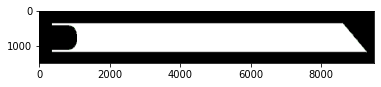

semi :  torch.Size([1, 65, 38, 376])
desc :  torch.Size([1, 256, 38, 376])
semi :  torch.Size([1, 65, 38, 376])
desc :  torch.Size([1, 256, 38, 376])
pts_int :  torch.Size([1, 500, 2])
pts_offset :  torch.Size([1, 500, 2])
pts_desc :  torch.Size([1, 500, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


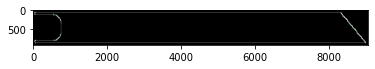

In [79]:
img_path = '/home/gzr/Data/linemod_2d/DATA/steel_test/08159/matchedMask.jpg'
visualize(img_path)
img_path = '/home/gzr/workspace/SuperPointPretrainedNetwork-master/assets/template_image/canny2.jpg'
visualize(img_path)